In [1]:
# Import packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime as dt
import yfinance as yf
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Processing user input

In [2]:
# input requested Ticker to be analyzed:
ticker = input("Enter a ticker symbol of the asset you want to get processed: ")

# Download the data on the specified asset
df = yf.download(ticker, period = "5y", interval = "1d")

Enter a ticker symbol of the asset you want to get processed: AAPL
[*********************100%%**********************]  1 of 1 completed


# Trading Strategies

## Baseline strategies

### 1. Random Trading

In [3]:
def simulate_trade(ticker_symbol, initial_balance, num_days, data = None, description = True) -> float:
    """Takes in ticker of a chosen stock, initial balance to trade with,
    and number of days to trade for, performs the random buying and selling strategy
    for for the most recent days possible, and returns the description of trades and final
    account balance"""
    
    # Download historical stock data if not given
    if data is None:
        stock_data = yf.download(ticker_symbol, 
                        start=dt.datetime.now() - dt.timedelta(days=num_days),
                        end=dt.datetime.now())
    elif isinstance(data, pd.core.frame.DataFrame):
        stock_data = data
    else:
        raise ValueError("Invalid type for 'data'. Expected DataFrame or None.")
    
    # Initialize variables for account balance and stock quantity held
    balance = initial_balance
    stock_quantity = 0

    # Define the trades for each day
    for day in range(1, len(stock_data) + 1):
        action = random.choice(['buy', 'sell'])

        # Get the stock price for the current day
        current_price = stock_data['Adj Close'][day - 1]

        if action == 'buy':
            # Randomly determine the quantity to buy
            buy_quantity = random.randint(1, 10)

            total_cost = buy_quantity * current_price

            if total_cost <= balance:
                # Perform the purchase
                stock_quantity += buy_quantity
                balance -= total_cost
                
                # Describe trade if specified
                if description == True:
                    print(f"Day {day}: Bought {buy_quantity} stocks at ${current_price:.2f} each.")

        elif action == 'sell' and stock_quantity > 0:
            # Randomly determine the quantity to sell
            sell_quantity = random.randint(1, stock_quantity)

            total_earning = sell_quantity * current_price

            # Perform the sale
            stock_quantity -= sell_quantity
            balance += total_earning
            
            # Describe the trade if specified
            if description == True:
                print(f"Day {day}: Sold {sell_quantity} stocks at ${current_price:.2f} each.")

    # Sell remaining stocks on the last day
    if stock_quantity > 0:
        total_earning = stock_quantity * current_price
        balance += total_earning
        
        if description == True:
            print(f"Final day: Sold remaining {stock_quantity} stocks at ${current_price:.2f} each.")

    if description == True:
        print(f"Final balance: ${balance:.2f}")
    
    else:
        return balance

In [4]:
# Simulate trading cycles (30-days)
trade_simulations = [simulate_trade(ticker, 100, 30, data = df, description = False) for i in range(1000)]

Text(0.5, 1.0, 'Avg: $111.03\nSD: $12.68')

<Figure size 1000x400 with 0 Axes>

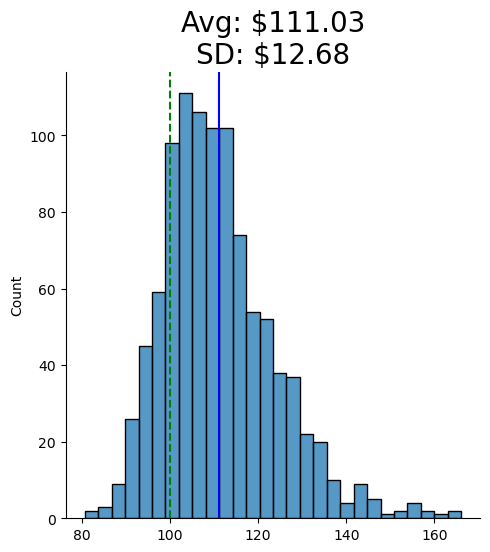

In [5]:
# Plot the trade simulations distribution
plt.figure(figsize=(10,4))
sns.displot(trade_simulations)
plt.axvline(np.mean(trade_simulations), color='b', linestyle='-')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(trade_simulations),2), round(np.std(trade_simulations),2)), fontsize=20)

### 2. Buy and Hold

In [6]:
def buy_and_hold(ticker_symbol: str, initial_balance: float, num_days: int, data = None, description = True):
    """Takes in the ticker symbol, the initial investment, and the
    time window in days, intended to hold the investment, then returns
    the final investment balance after selling the position at the end of the period"""
    
    # Download historical stock data if not given
    if data is None:
        stock_data = yf.download(ticker_symbol, 
                        start=dt.datetime.now() - dt.timedelta(days=num_days),
                        end=dt.datetime.now())
    elif isinstance(data, pd.core.frame.DataFrame):
        stock_data = data
    else:
        raise ValueError("Invalid type for 'data'. Expected DataFrame or None.")
    
    # Initialize variables for account balance and stock quantity held
    stock_quantity = initial_balance / stock_data["Adj Close"][0]
    
    # Final balance
    final_balance = stock_quantity * stock_data["Adj Close"][-1]
    
    if description == True:
        print(f"Final balance: ${final_balance:.2f}")
    
    else:
        return final_balance


In [7]:
buy_and_hold(ticker, 10000, 30)

[*********************100%%**********************]  1 of 1 completed
Final balance: $10015.63


## Data based strategies

### Moving Average 

In [8]:
# Simple moving average function
def SMA(data: pd.DataFrame, price_info: str, period: int = 30):
    """Takes in a dataframe with historical prices of an asset,
    type of price information used, such as Close or
    Adjusted close, and the rolling window period, and calculates
    the average"""
    
    return data[price_info].rolling(window = period).mean()

In [9]:
# Function to produce trading signals based on an MA strategy
def MA_strategy(data: pd.DataFrame, long_ma: int, short_ma: int) -> pd.DataFrame:
    """Takes in a time series dataframe with the asset information,
    produces buy and sell signals based on a crossover strategy
    with specified period from which to calculate the 
    short term and long term moving averages."""
    
    # Add the moving average columns to the dataset
    data["LongMA"] = SMA(data, "Open", period = long_ma)
    data["ShortMA"] = SMA(data, "Open", period = short_ma)
    
    # Define buy and sell signals
    data["Signal"] = np.where(data["ShortMA"] > data["LongMA"], 1, 0)
    data["Position"] = data["Signal"].diff()
    data["Buy"] = np.where(data["Position"] == 1, data["Open"], np.NaN)
    data["Sell"] = np.where(data["Position"] == -1, data["Open"], np.NaN)
    
    return data

In [10]:
df_ma = MA_strategy(data = df, long_ma = 50, short_ma = 20)

<function matplotlib.pyplot.show(close=None, block=None)>

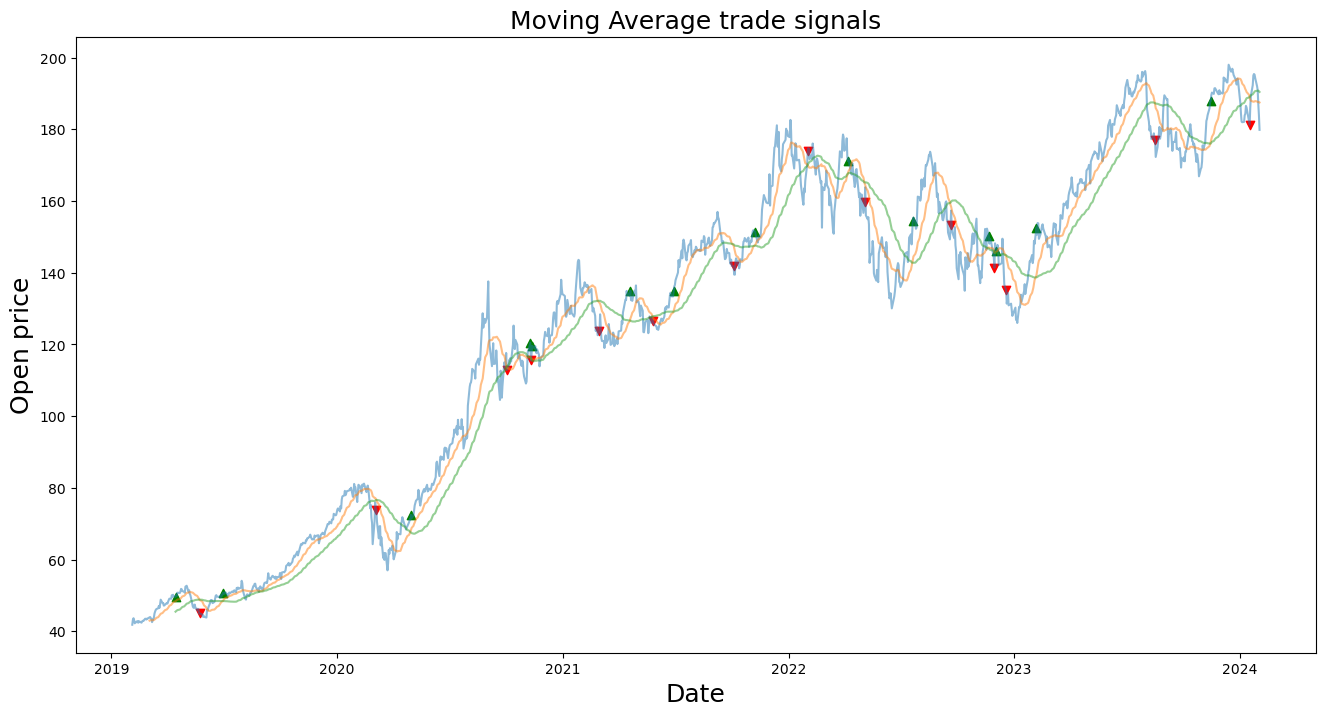

In [11]:
# Visualization of Buy and sell signals using Moving Average
plt.figure(figsize = (16,8))
plt.title("Moving Average trade signals", fontsize = 18)
plt.plot(df_ma["Open"], alpha = 0.5)
plt.plot(df_ma["ShortMA"], alpha = 0.5)
plt.plot(df_ma["LongMA"], alpha = 0.5)
plt.scatter(df_ma.index, df_ma["Buy"], alpha = 1, label = "Buy Signal", marker = "^", color = "green")
plt.scatter(df_ma.index, df_ma["Sell"], alpha = 1, label = "Sell Signal", marker = "v", color = "red")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Open price", fontsize = 18)
plt.show

### XGBoost Regression 

In [12]:
# Trading strategy
def xgb_signals(data: pd.DataFrame, test_size: float = 0.2) -> pd.DataFrame:
    """Takes in a Pandas dataframe containing information on an asset
    from Yahoo Finance and the proportion of the dataset to be used for testing performance,
    and returns a dataframe with buy and sell signals for a specified period"""
    
    # Creating a features dataset and target variable dataset
    features = data[["Open", "Volume"]]
    target = data["Close"]
    
    # Train test split
    feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=test_size, shuffle=False)
      
    # train the model
    model = xgb.XGBRegressor()
    model.fit(feature_train, target_train)
               
    # Predicted values of the model
    predictions = model.predict(feature_test)
               
    # Create a dataframe with lagged version of close prices
    lagged_actual_prices = target_test.shift(1)
    
    # Define signal conditions
    conditions = [
        predictions > lagged_actual_prices,
        predictions < lagged_actual_prices
    ]
    values = [1, -1]
    
    # Set up the trade signals DataFrame
    trade_signals_df = pd.DataFrame(index=lagged_actual_prices.index)
    
    # Include the trade signals in the dataframe
    trade_signals_df['Trade_Signal'] = np.select(conditions, values, default=0)
    
    # Filter only rows where Trade signal is not neutral
    trade_signals_df = trade_signals_df[trade_signals_df['Trade_Signal'] != 0]
    
    # Add the close prices for the days with trade signals
    trade_signals_df['Close_Price_On_Trade'] = target_test.loc[trade_signals_df.index]
    
    return trade_signals_df

In [13]:
df_trading = xgb_signals(df)
df_trading

,Trade_Signal,Close_Price_On_Trade
Date,,
2023-02-03,1,154.500000
2023-02-06,-1,151.729996
2023-02-07,-1,154.649994
2023-02-08,-1,151.919998
2023-02-09,1,150.869995
...,...,...
2024-01-29,-1,191.729996
2024-01-30,-1,188.039993
2024-01-31,-1,184.399994


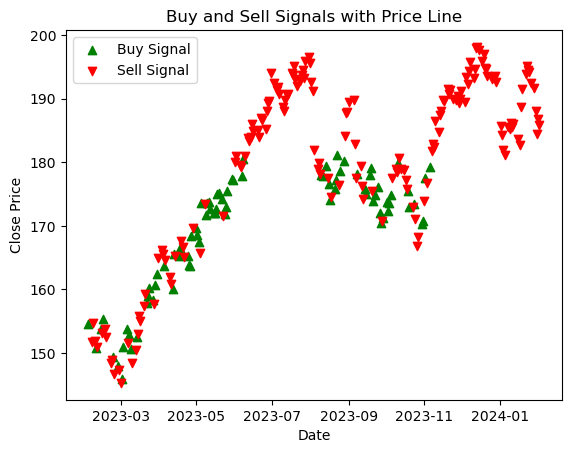

In [14]:
 # Plot buy and sell signals
buy_signals = df_trading[df_trading['Trade_Signal'] == 1]
sell_signals = df_trading[df_trading['Trade_Signal'] == -1]
    
plt.scatter(buy_signals.index, buy_signals['Close_Price_On_Trade'], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close_Price_On_Trade'], marker='v', color='r', label='Sell Signal')
    
# Customize the plot
plt.title('Buy and Sell Signals with Price Line')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()